In [5]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("/content/quantile-regression-data.csv")

# Generate the linear program

In [7]:
def quantile_regression(n,q, df):
    # Constraint matrix

    one_all = np.ones(n)
    x_value = df.loc[:, "x"]
    df_A = pd.DataFrame({"b_0" : one_all, "b_1" : x_value})

        #  Plus columns
    plus_columns = np.eye(n, n)
    df_A_bis =  pd.DataFrame(plus_columns, columns=[f"plus_{i+1}" for i in range(n)])

        # Minus columns
    minus_columns = np.eye(n, n) * -1
    df_A_bis = pd.concat([df_A_bis, pd.DataFrame(minus_columns, columns=[f"minus_{i+1}" for i in range(n)])], axis=1)

        # Reorganize
    reorganize = [f"plus_{i//2 +1}" if i % 2 == 0 else f"minus_{i//2+1}" for i in range(len(df_A_bis.columns))]
    df_A_bis = df_A_bis[reorganize]

    df_A = pd.concat([df_A, df_A_bis], axis=1)

    A = np.array(df_A)


    # Constraint parameter is the dependant variables
    b = np.array(df.loc[:, 'y'])

    # Cost vector is the ponderation of the point for the quantile regression
    c =  np.array([q if i % 2 == 0 else 1 for i in range(0, 2*n + 2)]) - np.array([0 if i % 2 == 0 else q for i in range(0, 2*n + 2)])
    c[0], c[1] = 0, 0

    nb_variables = len(c)

    return nb_variables, c, A, b

# Find the best solver

In [20]:
list_q = [0.2, 0.8]
solvers = ['CLARABEL', 'ECOS', 'ECOS_BB', 'GLPK_MI', 'OSQP', 'PIQP', 'SCIPY', 'SCS']
values = []
durations = []

for q in list_q :

    # Linear program
    nb_variables, c, A, b = quantile_regression(len(df),  q, df)

    x = cp.Variable(nb_variables)
    prob = cp.Problem(cp.Minimize(c.T@x),
                    [A @ x == b, x[2:] >= 0])

    for solver in solvers:

        solver = getattr(cp, solver)
        start_time = time.time()
        result = prob.solve(solver=solver)
        duration = time.time() - start_time

        values.append(prob.value)
        durations.append(duration)


In [23]:

df_values = pd.DataFrame([values[:len(values)//2], values[len(values)//2 :]], index = ['0.2', '0.8'], columns = solvers)
df_durations = pd.DataFrame([durations[:len(durations)//2], durations[len(durations)//2 :]], index = ['0.2', '0.8'], columns = solvers)

In [33]:
df_values_sorted = (df_values.iloc[0, :] + df_values.iloc[1, :])/2
df_values_sorted.sort_values(ascending = True)

,0
ECOS,80333.846223
ECOS_BB,80333.846223
SCIPY,80333.846300
GLPK_MI,80333.846300
PIQP,80333.846302
CLARABEL,80333.846393
OSQP,80333.849485
SCS,80333.867064


In [34]:
df_durations_sorted = (df_durations.iloc[0, :] + df_durations.iloc[1, :])/2
df_durations_sorted.sort_values(ascending = True)

,0
PIQP,1.485402
ECOS,1.775091
ECOS_BB,1.967212
CLARABEL,2.080892
SCIPY,5.085726
OSQP,7.551843
SCS,10.658569
GLPK_MI,15.099342


# Solve the linear program

In [36]:
def solve_quantile_regression(df, q):

    nb_variables, c, A, b = quantile_regression(len(df), q, df)

    # Define and solve  problem
    x = cp.Variable(nb_variables)
    prob = cp.Problem(cp.Minimize(c.T@x),
                    [A @ x == b, x[2:] >= 0])

    # With the simplex method
    prob.solve(solver = cp.ECOS)


    # Sample data
    X = np.array(df.loc[:, "x"])
    Y = np.array(df.loc[:, "y"])

    # Regression coefficients obtained from optimization
    beta_0 = x.value[0]
    beta_1 = x.value[1]


    # Calculate fitted values
    Y_fit = beta_1 * X + beta_0


    return prob, x, X, Y, Y_fit

The optimal value is  79953.33849885974
A solution x is
[-2.96038663e+01  1.98858256e+00  4.02842751e+01 ... -1.19120905e-08
  4.92558848e+01 -1.17794678e-08]
A dual solution is
[-0.2 -0.2 -0.2 ... -0.2 -0.2 -0.2]


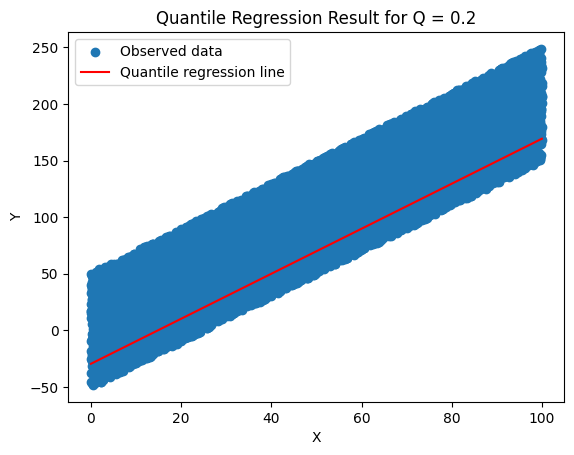

In [37]:
Q = 0.2
prob, x, X, Y, Y_fit = solve_quantile_regression(df, Q)

# Plot optimization result
print("The optimal value is ", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)

# Plot observed data
plt.scatter(X, Y, label='Observed data')

# Plot regression line
plt.plot(X, Y_fit, color='red', label='Quantile regression line')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile Regression Result for Q = 0.2')
plt.legend()
plt.show()

The optimal value is  80714.35394685183
A solution x is
[ 3.00827575e+01  2.00687036e+00 -3.78475377e-09 ... -3.64201664e-09
 -3.94090048e-09  1.22593370e+01]
A dual solution is
[ 0.2  0.2  0.2 ...  0.2 -0.8  0.2]


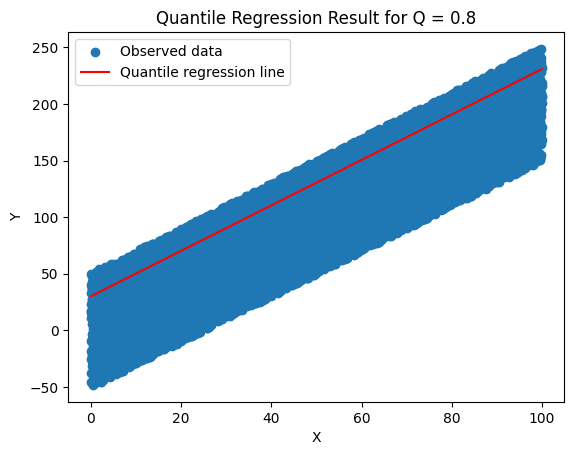

In [38]:
Q = 0.8
prob, x, X, Y, Y_fit = solve_quantile_regression(df, Q)

# Plot optimization result
print("The optimal value is ", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)

# Plot observed data
plt.scatter(X, Y, label='Observed data')

# Plot regression line
plt.plot(X, Y_fit, color='red', label='Quantile regression line')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile Regression Result for Q = 0.8')
plt.legend()
plt.show()